In [38]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
#import json
import os

pd.set_option('display.max_rows', 2500)
pd.set_option('display.max_columns', 100)

# stats packages to fit classification models
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.calibration import calibration_curve

# importing xG xGils library
import xGils.xG as xG

pd.options.mode.chained_assignment = None

# **xG Feature Engineering**

1. Load in pre-made Opta dataset.
2. Load in synthetic data.
2. Add additional features:
    * Basic features;
    * Added features;
    * Advanced features.
3. Fit logistic / probit regression model.

**Note, we'll have to construct some of the features before we construct a `df_shots` dataframe.**

**Will also want to integrate the synthetic shots and see if that improves things.**
(Will have to generate some dummy data for the synthetic shots).

## **1) Loading Opta dataset (which includes Bayesian xT)**

In [2]:
%%time

df = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Analysis Ready/Opta Bayesian xT/Bayesian_Opta_xT.csv')

# converting the timestamp string to a datetime
df['timeStamp'] = pd.to_datetime(df.timeStamp, format='%Y-%m-%d %H:%M:%S.%f')
df['kickOffDateTime'] = pd.to_datetime(df.kickOffDateTime, format='%Y-%m-%d %H:%M:%S.%f')

print (f'{len(df)} rows loaded.\n')

df.head()


3126182 rows loaded.

CPU times: user 13.3 s, sys: 1.39 s, total: 14.7 s
Wall time: 15 s


,competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventType,eventSubType,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,xT
0,English Premier League,2017/18,1,24212,918893,59966,Alexandre Lacazette,Forward,Striker,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,50.0,50.7,28.8,30.1,0:1,2017-08-11 19:46:04.968,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,1,52.500,34.476,30.240,20.468,-0.003278
1,English Premier League,2017/18,1,24212,918893,156074,Rob Holding,Defender,FullBack,3,67,NaN,1.0,NaN,NaN,attack,Pass,1,29.7,26.7,52.3,21.5,0:2,2017-08-11 19:46:05.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,2,31.185,18.156,54.915,14.620,0.003008
2,English Premier League,2017/18,1,24212,918893,37605,Mesut Özil,Forward,AttackingMidfielder,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,52.8,21.3,44.3,20.7,0:5,2017-08-11 19:46:08.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,5,55.440,14.484,46.515,14.076,-0.001186
3,English Premier League,2017/18,1,24212,918893,153256,Mohamed Elneny,Midfielder,CentralMidfielder,3,66,NaN,1.0,NaN,NaN,attack,Pass,1,44.0,19.6,50.3,4.2,0:7,2017-08-11 19:46:10.554,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,7,46.200,13.328,52.815,2.856,-0.000542
4,English Premier League,2017/18,1,24212,918893,98745,Héctor Bellerín,Midfielder,RightMidfielder,3,95,NaN,NaN,NaN,NaN,attack,Pass,1,51.0,4.2,70.5,5.0,0:9,2017-08-11 19:46:13.519,1,Arsenal,3,Leicester City,13,2017-08-11 19:45:00,0,9,53.550,2.856,74.025,3.400,0.005850


### **Setting useful event types (may not need this)**

In [3]:
# pass events (inc. crosses)
opta_successful_pass_events = ['2nd Assist','Assist','Chance Created','Cross','Pass']
opta_failed_pass_events = ['Failed Pass','Offside Pass']

# dribble events
opta_successful_dribble_events = ['Dribble']
opta_failed_dribble_events = ['Failed Dribble']

# shot events
opta_successful_shot_events = ['Goal']
opta_failed_shot_events = ['Hit Woodwork','Miss','Missed Penalty','Penalty Saved','Shot Blocked','Shot Saved']

opta_events_successful = opta_successful_pass_events + opta_successful_dribble_events + opta_successful_shot_events
opta_events_relevant = opta_successful_pass_events + opta_failed_pass_events + opta_successful_dribble_events + opta_failed_dribble_events + opta_successful_shot_events + opta_failed_shot_events

opta_events_relevant

['2nd Assist',
 'Assist',
 'Chance Created',
 'Cross',
 'Pass',
 'Failed Pass',
 'Offside Pass',
 'Dribble',
 'Failed Dribble',
 'Goal',
 'Hit Woodwork',
 'Miss',
 'Missed Penalty',
 'Penalty Saved',
 'Shot Blocked',
 'Shot Saved']

## **2) Loading in Synthetic Shot Data**

In [4]:
df_synthetic = pd.read_csv('/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Data/Synthetic/Synthetic_Shots.csv')

## **3) Feature Engineering**

#### Binary response variable
* Shot success = 1

#### Simple features:
* Initial $x$
* Initial $y$

#### Added features:
* Initial $x^2$
* Initial $y^2$
* Initial $xy$
* Shooting angle to centre of goal
* Distance to goal (metres), $D$
* $D^2$
* $D^3$
* Amount of goal the shooter can see (requires some trigonometry)

#### Contextual features:
* Binary home/away flag (home=1)
* Game state (the point-in-time difference in goals between the two sides)
* Headcount difference (e.g. is equal to 1 if 11 Vs 10)
* Player possession duration.
* Cumulative team possession sequence duration.
* Passing index within possession sequence.

### **Applying Contextual Feature Engineering Functions**

In [5]:
%%time

df = xG.xG_contextual_feature_engineering(df)

CPU times: user 5min 15s, sys: 13.8 s, total: 5min 29s
Wall time: 3min 33s


### **Applying Geometric Feature Engineering Functions**

In [85]:
%%time

df_shots = xG.xG_geometric_shot_feature_engineering(df)

df_shots['homeFlag'] = (df.playerTeamId == df.homeTeamId).astype(int)

CPU times: user 405 ms, sys: 553 ms, total: 958 ms
Wall time: 1.09 s


In [86]:
df_shots.sort_values('y1_m').head()

,competition,season,seasonIndex,gameMonthIndex,matchId,playerId,playerName,position,detailedPosition,playerTeamId,minsPlayed,subIn,subOut,replacedReplacingPlayerId,booking,eventId,eventType,eventSubType,eventTypeId,x1,y1,x2,y2,gameTime,timeStamp,periodId,homeTeamName,homeTeamId,awayTeamName,awayTeamId,kickOffDateTime,minute,second,x1_m,y1_m,x2_m,y2_m,possessionTeamId,possessionSequenceIndex,possessionStartTime,possessionTimeSec,playerPossessionTimeSec,goalDelta,numReds,goalScoredFlag,xT,x_dist_goal,x_dist_goal_2,c1_m,c1_m_2,vec_x,vec_y,D,Dsquared,Dcubed,a,aShooting,homeFlag
43530,English Premier League,2020/21,4,24257,2128655,210407,Matheus Pereira,Forward,SencondStriker,35,93,NaN,NaN,NaN,NaN,3108284,shot,Goal,16,99.4,1.3,100.0,47.4,26:10,2021-05-19 20:41:24.590,1,West Bromwich Albion,35,West Ham United,21,2021-05-19 20:15:00,26,10,104.37,0.884,105.00,32.232,35,103,2021-05-19 20:41:24.590,0.000,0.000,1,0,1,0.0,0.63,0.3969,33.116,1096.669456,0.63,0.884,1.085521,1.178356,1.279130,0.619179,0.004256,1
5193,Champions League,2017/18,1,24215,952430,83465,Vincent Aboubakar,Forward,Striker,201,93,NaN,NaN,NaN,NaN,370379,shot,Shot Saved,15,38.2,2.8,93.2,47.5,57:29,2017-11-21 18:15:11.998,2,Besiktas,378,FC Porto,201,2017-11-21 17:00:00,57,29,40.11,1.904,97.86,32.300,201,248,2017-11-21 18:15:05.589,6.409,1.465,0,0,0,0.0,64.89,4210.7121,32.096,1030.153216,64.89,1.904,64.917928,4214.337316,273586.044506,1.541463,0.090616,1
36847,English Premier League,2020/21,4,24251,2128382,61366,Kevin De Bruyne,Midfielder,AttackingMidfielder,43,93,NaN,NaN,NaN,NaN,2628356,shot,Shot Saved,15,66.4,3.2,92.4,49.1,24:40,2020-11-28 15:24:46.818,1,Manchester City,43,Burnley,90,2020-11-28 15:00:00,24,40,69.72,2.176,97.02,33.388,43,84,2020-11-28 15:24:06.458,40.360,3.510,2,0,0,0.0,35.28,1244.6784,31.824,1012.766976,35.28,2.176,35.347042,1249.413376,44163.067039,1.509196,0.114578,1
389,English Premier League,2017/18,1,24212,918908,13017,Wayne Rooney,Forward,Striker,11,89,NaN,1.0,NaN,Yellow Card,26600,shot,Miss,13,63.8,4.6,100.0,23.9,73:9,2017-08-21 21:32:46.835,2,Manchester City,43,Everton,11,2017-08-21 20:00:00,73,9,66.99,3.128,105.00,16.252,11,298,2017-08-21 21:32:46.835,0.000,0.000,1,0,0,0.0,38.01,1444.7601,30.872,953.080384,38.01,3.128,38.138491,1454.544484,55474.131488,1.488687,0.116161,1
6034,English Premier League,2017/18,1,24216,919062,80226,Serge Aurier,Defender,RightWingBack,6,93,NaN,NaN,NaN,NaN,431622,shot,Goal,16,83.2,4.6,100.0,53.3,39:32,2017-12-13 20:39:40.394,1,Tottenham Hotspur,6,Brighton and Hove Albion,36,2017-12-13 20:00:00,39,32,87.36,3.128,105.00,36.244,6,175,2017-12-13 20:39:12.290,28.104,0.664,1,0,1,0.0,17.64,311.1696,30.872,953.080384,17.64,3.128,17.915189,320.953984,5749.951168,1.395296,0.102865,0


---

# Model Application: Applying Four Models to Produce **xG** Variations to **Test** Data

In [87]:
# applying basic, added, and advanced models to test data
def apply_xG_model_to_test(models):
    """
    Applying the four different logistic regression models to produce four xG values
    """
    log_basic, log_added, log_adv, pro_adv = models
    
    print ('Applying models...')
    df_shots_test['xG_basic'] = log_basic.predict(df_shots_test)
    df_shots_test['xG_added'] = log_added.predict(df_shots_test)
    df_shots_test['xG_adv'] = log_adv.predict(df_shots_test)
    df_shots_test['xG_pro'] = pro_adv.predict(df_shots_test)
    print (f'Done applying {len(models)} models.')
    
    return df_shots_test

---

# Model Validation: Calibration Curves

In [88]:
def plot_calibration_curve(df_shots_test, show_advanced=1, save_output=0):

    fig = plt.figure(figsize=(10, 10))

    # Plotting perfect calibration (line y=x)
    plt.plot([0, 1], [0, 1], 'k:', label='Perfectly Calibrated Model')

    alpha = 0.6
    numBins = 25

    # FOUR calibration curves - Tricky to plot all four at a time, so just do a Simple Vs Advanced
    if show_advanced == 0:
        ## 1) Simple Model
        fraction_of_positives, mean_predicted_value = calibration_curve(df_shots_test.goalScoredFlag, df_shots_test.xG_basic, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Basic Model', alpha = alpha, color='red')

        ## 2) Added Model
        fraction_of_positives, mean_predicted_value = calibration_curve(df_shots_test.goalScoredFlag, df_shots_test.xG_added, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Added Features', alpha = alpha, color='blue')

    elif show_advanced == 1:
        ## 3) Advanced Model: Canonical (Logit) Link function
        fraction_of_positives, mean_predicted_value = calibration_curve(df_shots_test.goalScoredFlag, df_shots_test.xG_adv, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Advanced Features: Logit Link', alpha = alpha, color='black')

        ## 4) Advanced Model: Probit Link function
        fraction_of_positives, mean_predicted_value = calibration_curve(df_shots_test.goalScoredFlag, df_shots_test.xG_pro, n_bins=numBins)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label='Advanced Features: Probit Link', alpha = alpha, color='orange')

    plt.ylabel('Fraction of Successful Shots', fontsize=18)
    plt.xlabel('Mean xG', fontsize=18)

    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])

    plt.legend(loc="lower right", fontsize=18)
    #plt.title('Calibration Plot', fontsize=24)

    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)

    plt.tight_layout()
    
    if save_output == 1:
        plt.savefig(f'/Users/christian/Desktop/University/Birkbeck MSc Applied Statistics/Project/Plots/xG Calibration/calibration_{show_advanced}.pdf', dpi=300, format='pdf', bbox_inches='tight')
    
    return plt.show()

In [89]:
def calculate_model_metrics(df_shots_test, xGtype='xG_adv', log_reg_decision_threshold = 0.65):
    '''
    Applies Logistic Regression Decision Threshold (i.e. applying the model to attribute whether a pass would or would have not been successful)
    And calculates a bunch of related metrics
    '''
    
    df_shots_test['predictedSuccess'] = df_shots_test[xGtype].apply(lambda x: 1 if x > log_reg_decision_threshold else 0)

    brierScore = metrics.brier_score_loss(df_shots_test.goalScoredFlag, df_shots_test[xGtype])

    # precision = TRUE POSITIVE / (TRUE POSITIVE + FALSE POSITIVE)
    # ratio of correctly positive observations / all predicted positive observations
    precisionScore = metrics.precision_score(df_shots_test.goalScoredFlag, df_shots_test.predictedSuccess)

    # recall = TRUE POSITIVE / (TRUE POSITIVE + FALSE NEGATIVE)
    # ratio of correctly positive observations / all true positive observations (that were either correctly picked TP or missed FN)
    recallScore = metrics.recall_score(df_shots_test.goalScoredFlag, df_shots_test.predictedSuccess)

    # weighted average of precision and recall
    f1Score = metrics.f1_score(df_shots_test.goalScoredFlag, df_shots_test.predictedSuccess)

    AUCScore = metrics.roc_auc_score(df_shots_test.goalScoredFlag, df_shots_test.predictedSuccess)

    # overall accuracy score: ratio of all correct over count of all observations
    accuracyScore = metrics.accuracy_score(df_shots_test.goalScoredFlag, df_shots_test.predictedSuccess)

    return print (f'Brier Score: {brierScore}\n\nPrecision Score: {precisionScore}\n\nRecall Score: {recallScore}\n\nF1 Score: {f1Score}\n\nAUC Score: {AUCScore}\n\nAccuracyScore: {accuracyScore}')

---

# 4) Model Fitting

### Splitting `df_shots` into training and test dataset, stratifying the dependent variable

In [122]:
# splitting into a dataframe for training and dataframe for testing
## stratifying the successFlag
df_shots_train, df_shots_test = train_test_split(df_shots, test_size=0.35, stratify=df_shots.goalScoredFlag, random_state=1, shuffle=True)

print (f'Stratified Shot Success Rates:\n\nOverall: {100*np.round(df_shots.goalScoredFlag.mean(),3)}%\nTrain: {100*np.round(df_shots_train.goalScoredFlag.mean(), 3)}%\nTest: {100*np.round(df_shots_test.goalScoredFlag.mean(), 3)}%\n')


Stratified Shot Success Rates:

Overall: 10.8%
Train: 10.8%
Test: 10.8%



### Fitting basic model to **training** data:
* Starting X
* Starting Y

In [123]:
%%time

xG_model_basic = smf.glm(formula="goalScoredFlag ~ x_dist_goal + c1_m", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_basic.summary2()

CPU times: user 421 ms, sys: 59.5 ms, total: 480 ms
Wall time: 106 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            17347.9081  
Link Function:      logit            BIC:            -274722.9532
Dependent Variable: goalScoredFlag   Log-Likelihood: -8671.0     
Date:               2021-07-10 01:23 LL-Null:        -9757.6     
No. Observations:   28478            Deviance:       17342.      
Df Model:           2                Pearson chi2:   3.20e+04    
Df Residuals:       28475            Scale:          1.0000      
Method:             IRLS                                         
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -0.0876    0.0463   -1.8909  0.0586  -0.1783   0.0032
x_dist_goal  -0.1019    0.0032  -31.7253  0.0000  -0.1081  -0.0956
c1_m         -0.1226    0.0051  -24.0832  0.0000  -0.1325  -0.1126
=================================================================

"""

### Fitting addititional features:
* Starting X
* Starting Y
* X\*Y (Interaction Term)
* End X
* End Y
* Shooting Angle (Initial)
* Sub Event Type

In [124]:
%%time

xG_model_added = smf.glm(formula="goalScoredFlag ~  x_dist_goal + c1_m + a + aShooting +\
                    D + Dsquared", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_added.summary2()

CPU times: user 707 ms, sys: 75.7 ms, total: 782 ms
Wall time: 149 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            17160.4691  
Link Function:      logit            BIC:            -274877.3646
Dependent Variable: goalScoredFlag   Log-Likelihood: -8573.2     
Date:               2021-07-10 01:23 LL-Null:        -9757.6     
No. Observations:   28478            Deviance:       17146.      
Df Model:           6                Pearson chi2:   2.99e+04    
Df Residuals:       28471            Scale:          1.0000      
Method:             IRLS                                         
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept      2.6354    1.4786   1.7824  0.0747  -0.2626   5.5333
x_dist_goal   -0.2055    0.0385  -5.3350  0.0000  -0.2811  -0.1300
c1_m          -0.2123    0.0332  -6.3936  0.0000  -0.2774  -0.1472
a              5.8394    0.8137   7.1764  0.0000   4.2446   7.4342
aShooting      1.1239    0.1584   7.0959  0.0000   0.8134   1.4343
D             -0.1953    0.0654  -2.9852  0.0028  -0.3236  -0.0671
Dsquared       0.0022    0.0007   3.1101  0.0019   0.0008   0.0036
=================================================================

"""

### Fitting model to **training** data with advanced features, using two different link functions:

#### Features:

* Sub Event Name
* Starting X
* Starting Y
* Starting X\*Y (Interaction Term)
* End X
* End Y
* End X\*Y (Interaction Term)
* Start Y^2
* End Y^2
* Start Y^2 \* End Y^2 (Interaction Term)
* Start X^2
* End X^2
* Start X^2 \* End X^2 (Interaction Term)
* Distance to Goal (Initial)
* Passing Distance
* Passing Distance^2
* Passing Distance^3
* Passing Angle
* Shooting Angle (Initial)
* Shooting Angle (Change Before and After Pass)
* Transition Through Thirds (1->2, 2->3, etc.)
* Home / Away Flag
* Counter Attack Flag
* Number of Red Cards
* Game State (Delta Between Teams for Number of Goals Scored)
* Time of Current Possession Sequence
* Time of Passing Player Possession
* Passing Index Within Possession Sequence



#### Link Functions:
* Logit (Canonical link function for Binomial family of distributions)
* Probit


In [125]:
df_shots.columns


Index(['competition', 'season', 'seasonIndex', 'gameMonthIndex', 'matchId',
       'playerId', 'playerName', 'position', 'detailedPosition',
       'playerTeamId', 'minsPlayed', 'subIn', 'subOut',
       'replacedReplacingPlayerId', 'booking', 'eventId', 'eventType',
       'eventSubType', 'eventTypeId', 'x1', 'y1', 'x2', 'y2', 'gameTime',
       'timeStamp', 'periodId', 'homeTeamName', 'homeTeamId', 'awayTeamName',
       'awayTeamId', 'kickOffDateTime', 'minute', 'second', 'x1_m', 'y1_m',
       'x2_m', 'y2_m', 'possessionTeamId', 'possessionSequenceIndex',
       'possessionStartTime', 'possessionTimeSec', 'playerPossessionTimeSec',
       'goalDelta', 'numReds', 'goalScoredFlag', 'xT', 'x_dist_goal',
       'x_dist_goal_2', 'c1_m', 'c1_m_2', 'vec_x', 'vec_y', 'D', 'Dsquared',
       'Dcubed', 'a', 'aShooting', 'homeFlag'],
      dtype='object')

In [180]:
%%time

xG_model_adv = smf.glm(formula="goalScoredFlag ~  x_dist_goal +\
                    vec_y + a + aShooting*D +\
                    Dsquared + possessionSequenceIndex + possessionTimeSec + playerPossessionTimeSec +\
                    goalDelta + numReds", data=df_shots_train\
                 ,family=sm.families.Binomial()).fit()

xG_model_adv.summary2()

CPU times: user 807 ms, sys: 120 ms, total: 928 ms
Wall time: 216 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
=======================================================================
Model:                GLM                AIC:              14935.2536  
Link Function:        logit              BIC:              -277053.0388
Dependent Variable:   goalScoredFlag     Log-Likelihood:   -7454.6     
Date:                 2021-07-10 01:39   LL-Null:          -9757.6     
No. Observations:     28478              Deviance:         14909.      
Df Model:             12                 Pearson chi2:     3.11e+04    
Df Residuals:         28465              Scale:            1.0000      
Method:               IRLS                                             
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -6.5947   0.8868 -7.4363 0.0000 -8.3329 -4.8566
x_dist_goal             -0.2678   0.0434 -6.1711 0.0000 -0.3528 -0.1827
vec_y                    0.2490   0.0376  6.6193 0.0000  0.1753  0.3228
a                        7.9182   1.0654  7.4319 0.0000  5.8300 10.0063
aShooting                5.3576   1.3282  4.0338 0.0001  2.7544  7.9608
D                       -0.2118   0.0710 -2.9843 0.0028 -0.3509 -0.0727
aShooting:D             -0.1275   0.0407 -3.1326 0.0017 -0.2073 -0.0477
Dsquared                 0.0032   0.0009  3.7247 0.0002  0.0015  0.0049
possessionSequenceIndex -0.0009   0.0002 -4.0701 0.0000 -0.0013 -0.0005
possessionTimeSec        0.0021   0.0008  2.6766 0.0074  0.0006  0.0036
playerPossessionTimeSec  0.0095   0.0016  6.0893 0.0000  0.0064  0.0126
goalDelta                0.7295   0.0172 42.3189 0.0000  0.6958  0.7633
numReds                 -0.2309   0.1261 -1.8311 0.0671 -0.4780  0.0162
=======================================================================

"""

In [185]:
%%time

# logit = canonical link
# probit
# cloglog

xG_model_adv_probit = smf.glm(formula="goalScoredFlag ~  x_dist_goal +\
                    vec_y + a + aShooting*D +\
                    Dsquared + possessionSequenceIndex + possessionTimeSec + playerPossessionTimeSec +\
                    goalDelta + numReds", data=df_shots_train\
                 ,family=sm.families.Binomial(link=sm.families.links.probit)).fit()

xG_model_adv_probit.summary2()

/Users/christian/anaconda2/envs/py37_football/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  if __name__ == '__main__':


CPU times: user 2.1 s, sys: 193 ms, total: 2.29 s
Wall time: 428 ms


<class 'statsmodels.iolib.summary2.Summary'>
"""
                   Results: Generalized linear model
=======================================================================
Model:                GLM                AIC:              14954.7723  
Link Function:        probit             BIC:              -277033.5201
Dependent Variable:   goalScoredFlag     Log-Likelihood:   -7464.4     
Date:                 2021-07-10 01:40   LL-Null:          -9757.6     
No. Observations:     28478              Deviance:         14929.      
Df Model:             12                 Pearson chi2:     4.21e+04    
Df Residuals:         28465              Scale:            1.0000      
Method:               IRLS                                             
-----------------------------------------------------------------------
                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               -3.3711   0.4375 -7.7053 0.0000 -4.2286 -2.5136
x_dist_goal             -0.1413   0.0222 -6.3580 0.0000 -0.1849 -0.0978
vec_y                    0.0948   0.0179  5.2921 0.0000  0.0597  0.1299
a                        3.7878   0.5392  7.0246 0.0000  2.7310  4.8447
aShooting                2.3616   0.6999  3.3742 0.0007  0.9898  3.7334
D                       -0.0779   0.0339 -2.3007 0.0214 -0.1442 -0.0115
aShooting:D             -0.0513   0.0216 -2.3790 0.0174 -0.0935 -0.0090
Dsquared                 0.0016   0.0004  3.7687 0.0002  0.0007  0.0024
possessionSequenceIndex -0.0003   0.0001 -2.2767 0.0228 -0.0005 -0.0000
possessionTimeSec        0.0012   0.0004  2.8030 0.0051  0.0004  0.0021
playerPossessionTimeSec  0.0046   0.0009  5.4331 0.0000  0.0030  0.0063
goalDelta                0.3880   0.0092 42.3515 0.0000  0.3700  0.4059
numReds                 -0.1268   0.0669 -1.8943 0.0582 -0.2579  0.0044
=======================================================================

"""

---

# 5) Applying models to **test** data

1. Basic model: just starting position features;
2. Added model: including features outlined in the problem statement;
3. Advanced model: Logit link - added extra **x** features
4. Advabced model: Probit link (same features as above)

In [186]:
df_shots_test = apply_xG_model_to_test([xG_model_basic, xG_model_added, xG_model_adv, xG_model_adv_probit])


Applying models...
Done applying 4 models.


---


# 6) Model Validation: Calibration Curves of Models Fit to **Test** Data

### Calibration Curve: Basic Vs Added Models

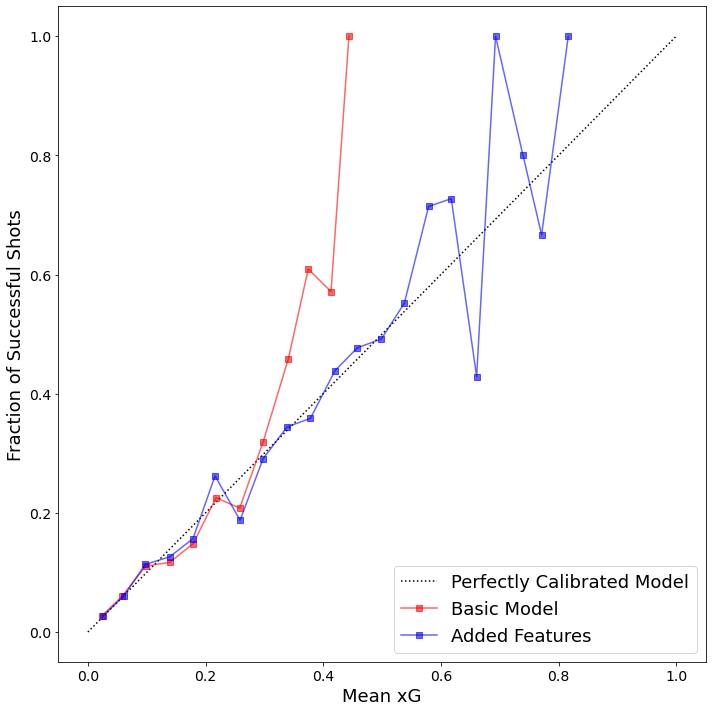

In [187]:
plot_calibration_curve(df_shots_test, show_advanced=0, save_output=1)

### Calibration Curve - Advanced Models: Logit Vs Probit

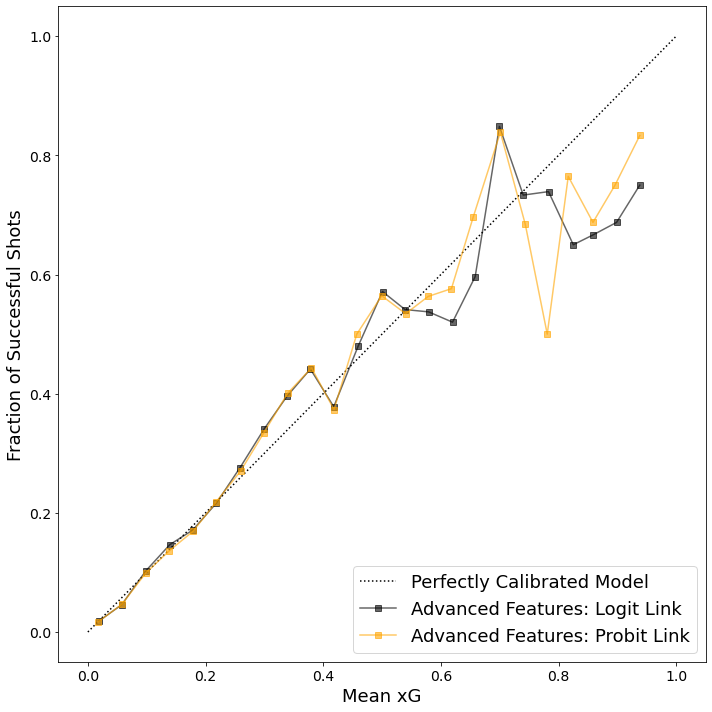

In [188]:
plot_calibration_curve(df_shots_test, show_advanced=1, save_output=1)

---

&nbsp;

&nbsp;

&nbsp;

# 7) Applying Logistic Regression Classifier and Calculating Model Fit Metrics

In [138]:
calculate_model_metrics(df_shots_test, 'xG_adv')

Brier Score: 0.07735204583730258

Precision Score: 0.689119170984456

Recall Score: 0.08021712907117008

F1 Score: 0.14370610480821178

AUC Score: 0.537915101056752

AccuracyScore: 0.8966416693837627
